# 20181017-final_contour_based_segmentation

# Goal
Segment the embryo from the background in order to clearly isolate changes in signal associated with germ band extension

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from imp import reload
import sys
sys.path.insert(0, '..')
import utilities as ut

from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import grid_points_in_poly

# Data Import

Read in hdf5 hyperstack as a 3d numpy array. Convert to float for ease of processing.

In [4]:
hst = img_as_float(ut.read_hyperstack('../data/wt_gbe_20180110.h5'))

Select a single image from the first timepoint to use as a test case for segmentation development

In [5]:
img = hst[0]

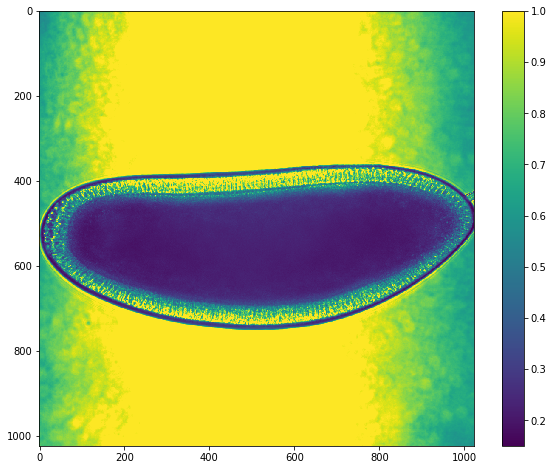

In [6]:
ut.imshow(img)

# Background Segmentation

In order to analyze any signal variation that is associated with germ band extension, we need to isolate the signal of the embryo from any background. This task is complicated by the nature of brightfield images where the intensity of the background ~1 is similar to the intensity of cells within the image. As a result we cannot use a simple threshold which would remove signal from within the embryo as well as from the background.

However, the embryo does have a clear dark line that separates the embryo itself from the background. We will take advantage of this clear line to separate the embryo from the background using contour based methods.

To start, we will approximate an ellipse that is slightly bigger than the size of the embryo, which will provide a starting point for contour fitting.

In [8]:
# Values to calculate the ellipse over using parametrized trigonometric fxns
s = np.linspace(0, 2*np.pi, 400)

# Define the approximate center of the embryo/ellipse
center_x = 500
center_y = 530

# Define the radius of the ellipse in x and y
radius_x = 550
radius_y = 250

# Calculate the position of the ellipse as a function of s
x = center_x + radius_x*np.cos(s)
y = center_y + radius_y*np.sin(s)
init = np.array([x, y]).T

Next we will use `skimage`'s `active_contour` method to fit our approximated ellipse to the contour of the embryo. The kwarg parameters for this function were copied based on the [active countour tutorial](http://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html). 

In [10]:
snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

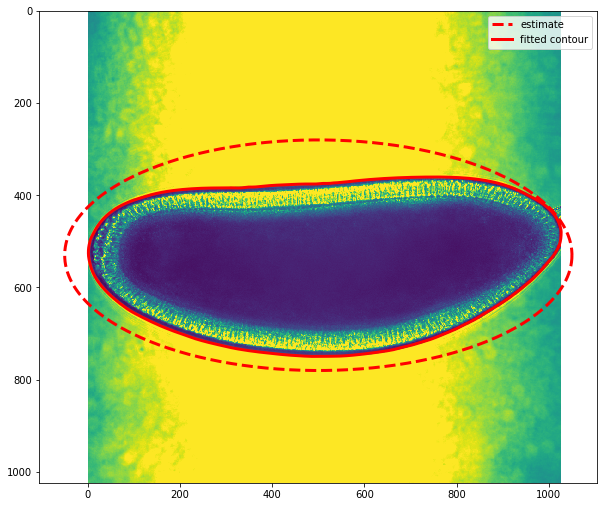

In [11]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(img)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3,label='estimate')
ax.plot(snake[:, 0], snake[:, 1], '-r', lw=3,label='fitted contour')
ax.legend()

The plot above shows our image overlaid with the approximated ellipse (dashed line) and the fitted counter (red continuous line). This contour follows the boundary between the embryo and the background. 

# Create background mask

Now that we have a estimated function `snake` that defines the boundary of the embryo and the background, we need to define a mask in the shape of the image that defines which points belong in the image. Skimage's `grid_points_in_poly` function takes a set of points defining a shape (`snake`) and identifies which points over a given raster area fall within the input shape.

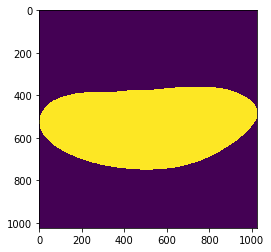

In [13]:
mask = grid_points_in_poly(img.shape, snake).T
plt.imshow(mask)

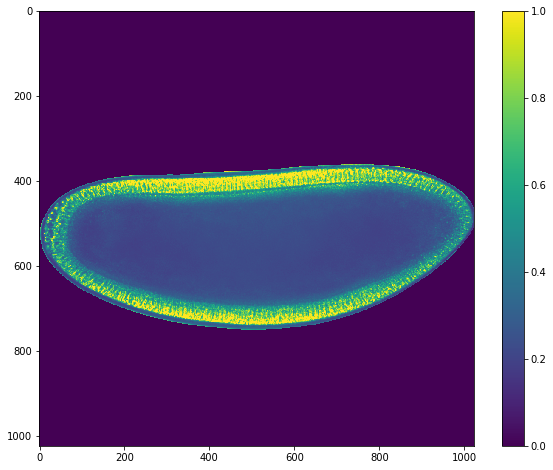

In [17]:
im_masked = img.copy()
im_masked[~mask] = 0
ut.imshow(im_masked)

# Write a function to fit a contour to a new embryo

In [20]:
def calc_ellipse(center_x,center_y,radius_x,radius_y):
    '''
    Calculate a parametrized ellipse based on input values
    '''
    
    # Values to calculate the ellipse over using parametrized trigonometric fxns
    s = np.linspace(0, 2*np.pi, 400)
    
    # Calculate the position of the ellipse as a function of s
    x = center_x + radius_x*np.cos(s)
    y = center_y + radius_y*np.sin(s)
    init = np.array([x, y]).T
    
    return(init)

In [21]:
def contour_embryo(img,init):
    '''
    Fit a contour to the embryo to separate the background
    Returns a masked image where all background points = 0
    '''
    
    # Fit contour based on starting ellipse
    snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)
    
    # Create boolean mask based on contour
    mask = grid_points_in_poly(img.shape, snake).T
    
    # Apply mask to image and set background to 0
    img[~mask] = 0
    
    return(img)

# Apply mask to hyperstack

Check ellipse approximation on first and last timepoints

In [22]:
center_x,center_y = 500,530
radius_x,radius_y = 550,250
ellipse = calc_ellipse(center_x,center_y,radius_x,radius_y)

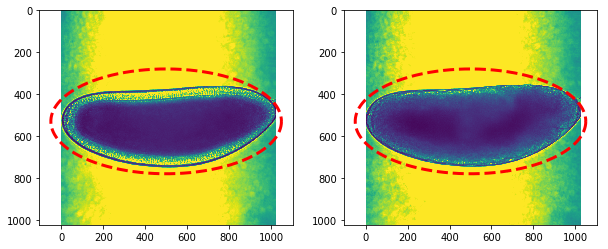

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(hst[0])
ax[0].plot(init[:,0],init[:,1],'--r',lw=3)
ax[1].imshow(hst[-1])
ax[1].plot(init[:,0],init[:,1],'--r',lw=3)

In [25]:
# Loop through each timepoint in hyperstack
for t in range(hst.shape[0]):
    hst[t] = contour_embryo(hst[t],ellipse)

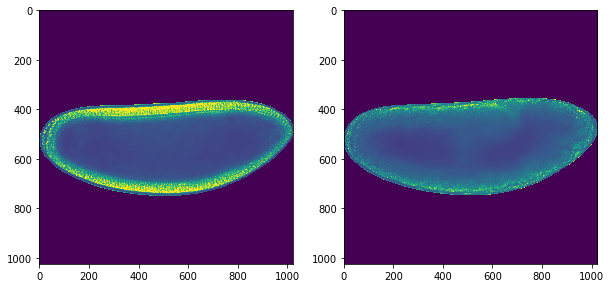

In [26]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(hst[0])
ax[1].imshow(hst[-1])